### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

from model import *
from process_images import *
from process_result import *

print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.5.0
TensorFlow version: 2.5.0


#### DRISHTI-GS

Carrega imagens de treino e teste com tamanho 512px.

In [2]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')
#-----------------------------------------------------------------------------------------------------------#
img_train = h5f['DRISHTI-GS/512 px/images']
cup_train = h5f['DRISHTI-GS/512 px/cup']
disc_train = h5f['DRISHTI-GS/512 px/disc']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

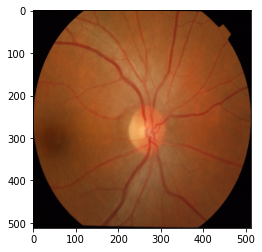

(50, 512, 512, 3)


(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [3]:
plt.imshow(img_train[45])
plt.show()
print(img_train.shape)
img_train, cup_train, disc_train, disc_locations

### Train images

In [4]:
red_channel_train = get_color_channel(0, img_train)
len(red_channel_train)

50

### Test images

In [5]:
red_channel_test = get_color_channel(0, img_test)
len(red_channel_test)

51

#### Generator of augmented data:

Testing the data generator and generator for augmented data:

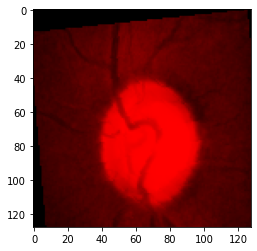

In [6]:
gen = data_generator(red_channel_train, cup_train, disc_locations, 128, 'train')
batch = next(gen)

plt.imshow(batch[0][0])
plt.show()

In [7]:
img_size = IMG_SIZE

X_test, Y_test = next(data_generator(red_channel_test, cup_test, disc_locations_test, img_size, train_or_test='test', batch_size=100, stationary=True))
len(X_test), len(Y_test)

(51, 51)

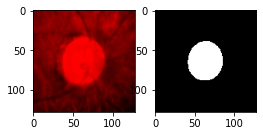

In [8]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.squeeze(X_test[10]), cmap=plt.cm.Greys_r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(Y_test[10]), cmap=plt.cm.Greys_r)
plt.show()

### Training and test cup

In [ ]:
epochs = NUM_EPOCHS
spe = SPE
model = create_compile_model(img_size)
history_cup = train(red_channel_train, 
                    cup_train, disc_locations, 
                    'cup_red', 
                    model, 
                    epochs, X_test, Y_test, img_size, spe)

Epoch 1/500
99/99 [==============================] - 25s 228ms/step - loss: 1.5957 - mean_IOU_gpu: 0.0861 - dice_metric: 0.1568 - val_loss: 1.4700 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 2/500
99/99 [==============================] - 24s 238ms/step - loss: 1.5483 - mean_IOU_gpu: 0.0439 - dice_metric: 0.0831 - val_loss: 1.4327 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 3/500
55/99 [===============>..............] - ETA: 10s - loss: 1.5899 - mean_IOU_gpu: 0.0152 - dice_metric: 0.0300

### Visual check

In [ ]:
pred_iou, pred_dice, pred_cup = predict(red_channel_test, X_test, Y_test, model, img_size)

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Training and test disc

In [ ]:
X_test, Z_test = next(data_generator(red_channel_test, disc_test, disc_locations_test, img_size, train_or_test='test', batch_size=100, stationary=True))

In [ ]:
num = 1
for i in range(num):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.squeeze(X_test[i]), cmap=plt.cm.Greys_r)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(Z_test[i]), cmap=plt.cm.Greys_r)
    plt.show()

In [ ]:
model_disc = create_compile_model(img_size)

history_disc = train(red_channel_train, 
                     disc_train, 
                     disc_locations, 
                     'disc_red', 
                     model_disc, epochs, X_test, Y_test, img_size, spe)

In [ ]:
pred_iou, pred_dice, pred_disc = predict(red_channel_test, X_test, Z_test, model_disc, img_size)

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

### Cálculo do CDR

In [ ]:
plot_results(history_cup, epochs)

In [ ]:
plot_results(history_disc, epochs)

In [ ]:
result, diametros_cup, diametros_disc = create_table_result(pred_cup, pred_disc, test_idx)
pd.DataFrame(data= result)
pd.DataFrame(data={'cup': diametros_cup, 'disc': diametros_disc})